<a href="https://colab.research.google.com/github/chigvintseva/UniProject-AST/blob/main/ast_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data generation

In [15]:
# STEP 1: Generate Synthetic Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Reproducibility
np.random.seed(42)

# Variables
num_people = 150
floors = ['Ground Floor', 'First Floor', 'Second Floor']
timestamps = pd.date_range(start='2025-06-20 09:00:00', periods=60, freq='T')

# Generate synthetic data
df = pd.DataFrame({
    'timestamp': np.random.choice(timestamps, num_people),
    'floor': np.random.choice(floors, num_people),
    'person_id': range(1, num_people + 1),
    'location_x': np.random.randint(0, 100, num_people),
    'location_y': np.random.randint(0, 100, num_people),
    'smoke_level': np.round(np.clip(np.random.normal(0.2, 0.1, num_people), 0, 1), 2),
    'alarm_status': np.random.choice(['OFF', 'ON'], num_people, p=[0.9, 0.1])
})


/tmp/ipython-input-15-3865519972.py:13: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  timestamps = pd.date_range(start='2025-06-20 09:00:00', periods=60, freq='T')


# Dataset visualisation

## Head

In [16]:
# 1.1 Print sample
df.head()


,timestamp,floor,person_id,location_x,location_y,smoke_level,alarm_status
0,2025-06-20 09:38:00,Ground Floor,1,98,31,0.19,OFF
1,2025-06-20 09:51:00,Second Floor,2,6,86,0.15,OFF
2,2025-06-20 09:28:00,Second Floor,3,15,62,0.21,OFF
3,2025-06-20 09:14:00,First Floor,4,89,85,0.25,OFF
4,2025-06-20 09:42:00,Ground Floor,5,59,50,0.37,OFF


## Bar chart - people per floor

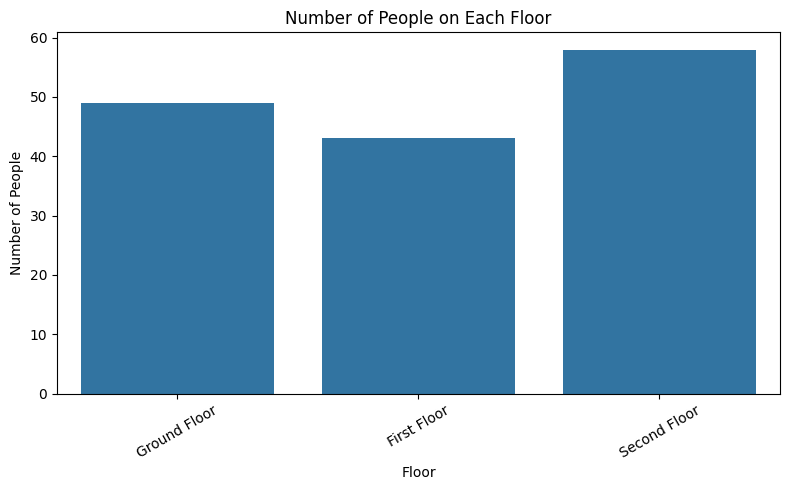

In [17]:
# Count people per floor
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='floor', order=floors)
plt.title("Number of People on Each Floor")
plt.ylabel("Number of People")
plt.xlabel("Floor")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


## Heat maps each floor

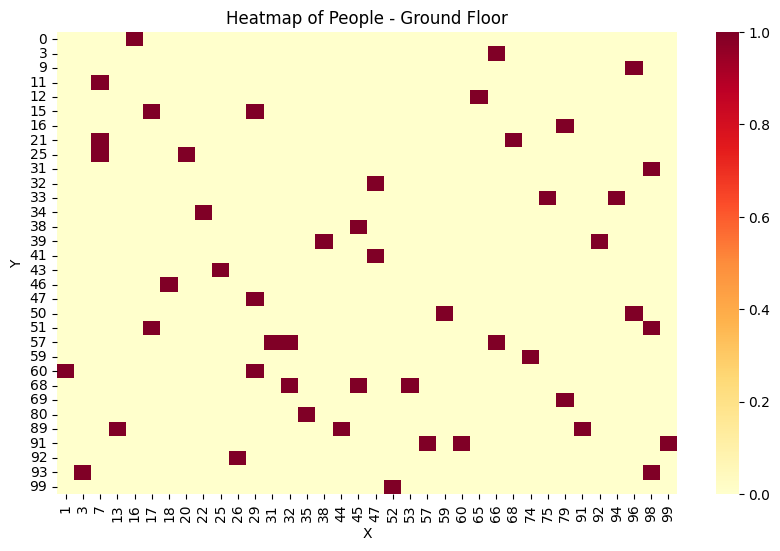

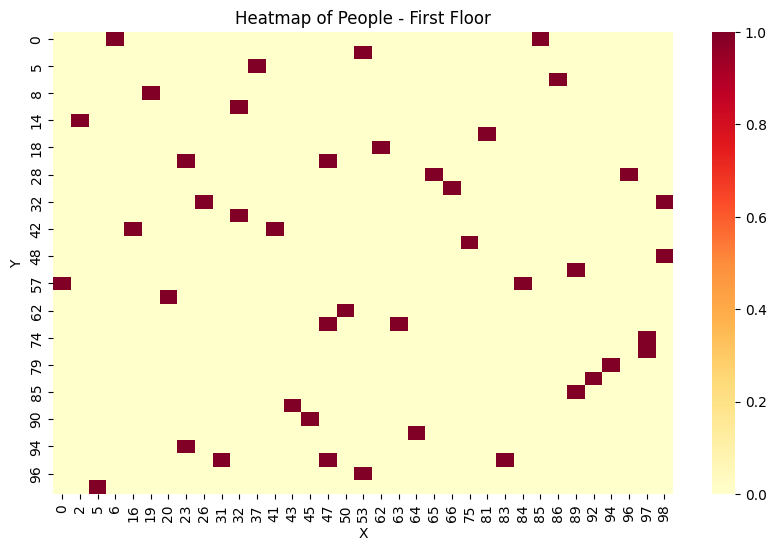

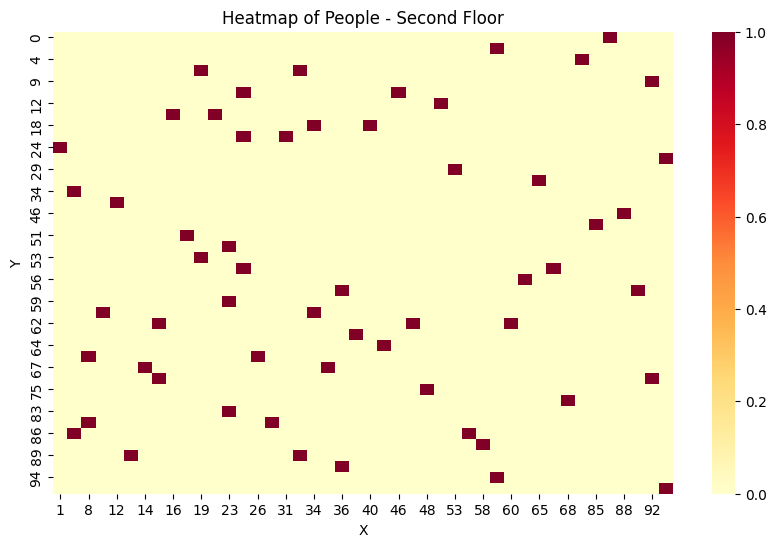

In [5]:
# Heatmaps of person density by location on each floor
for floor in floors:
    subset = df[df['floor'] == floor]
    heatmap_data = subset.groupby(['location_y', 'location_x']).size().unstack(fill_value=0)

    plt.figure(figsize=(10, 6))
    sns.heatmap(heatmap_data, cmap="YlOrRd")
    plt.title(f"Heatmap of People - {floor}")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()


# ABM

## Main

In [6]:
import random
from tqdm import tqdm

# Define exit coordinates (simplified assumption)
exit_coords = {
    'Ground Floor': (5, 5),
    'First Floor': (50, 0),
    'Second Floor': (95, 95)
}

def simulate_abm_evacuation(df, speed=3, max_time=120):
    evacuation_data = []

    for _, person in df.iterrows():
        x, y = person['location_x'], person['location_y']
        exit_x, exit_y = exit_coords[person['floor']]
        distance = np.sqrt((exit_x - x)**2 + (exit_y - y)**2)
        time_to_exit = int(distance / speed)
        evacuation_time = min(time_to_exit, max_time)

        evacuation_data.append({
            'person_id': person['person_id'],
            'floor': person['floor'],
            'evacuation_time': evacuation_time,
            'evacuated': evacuation_time < max_time
        })

    return pd.DataFrame(evacuation_data)


## S0

In [7]:
# Scenario 0 - Normal movement to exits
evac_base = simulate_abm_evacuation(df)

# KPIs
def collect_kpis(evac_data, label='Base Scenario'):
    avg_time = evac_data['evacuation_time'].mean()
    total_time = evac_data['evacuation_time'].sum()
    completion_rate = evac_data['evacuated'].mean()

    print(f"--- {label} ---")
    print(f"Average Evacuation Time: {avg_time:.2f} seconds")
    print(f"Total Evacuation Time: {total_time} seconds")
    print(f"Evacuation Completion Rate: {completion_rate*100:.2f}%\n")

collect_kpis(evac_base, label="ABM Scenario 0: Control")


--- ABM Scenario 0: Control ---
Average Evacuation Time: 22.65 seconds
Total Evacuation Time: 3397 seconds
Evacuation Completion Rate: 100.00%



## S1

In [8]:
# Increase smoke level on Ground Floor → lower speed
df_scenario1 = df.copy()
df_scenario1.loc[df_scenario1['floor'] == 'Ground Floor', 'smoke_level'] = 1.0

# Simulate evacuation with lower speed on Ground Floor
def simulate_fire_delay(df):
    data = []
    for _, person in df.iterrows():
        floor = person['floor']
        x, y = person['location_x'], person['location_y']
        exit_x, exit_y = exit_coords[floor]
        distance = np.sqrt((exit_x - x)**2 + (exit_y - y)**2)

        speed = 1.5 if floor == 'Ground Floor' else 3.0
        time_to_exit = int(distance / speed)
        evacuation_time = min(time_to_exit, 120)

        data.append({
            'person_id': person['person_id'],
            'floor': person['floor'],
            'evacuation_time': evacuation_time,
            'evacuated': evacuation_time < 120
        })
    return pd.DataFrame(data)

evac_scenario1 = simulate_fire_delay(df_scenario1)
collect_kpis(evac_scenario1, label="ABM Scenario 1: Fire near Ground Exit")


--- ABM Scenario 1: Fire near Ground Exit ---
Average Evacuation Time: 30.11 seconds
Total Evacuation Time: 4516 seconds
Evacuation Completion Rate: 100.00%



## S2

In [10]:
# Crowd on First Floor → reduce speed
def simulate_crowd_delay(df):
    data = []
    for _, person in df.iterrows():
        floor = person['floor']
        x, y = person['location_x'], person['location_y']
        exit_x, exit_y = exit_coords[floor]
        distance = np.sqrt((exit_x - x)**2 + (exit_y - y)**2)

        speed = 1.5 if floor == 'First Floor' else 3.0
        time_to_exit = int(distance / speed)
        evacuation_time = min(time_to_exit, 120)

        data.append({
            'person_id': person['person_id'],
            'floor': person['floor'],
            'evacuation_time': evacuation_time,
            'evacuated': evacuation_time < 120
        })
    return pd.DataFrame(data)

evac_scenario2 = simulate_crowd_delay(df)
collect_kpis(evac_scenario2, label="ABM Scenario 2: Overcrowding on First Floor")


--- ABM Scenario 2: Overcrowding on First Floor ---
Average Evacuation Time: 28.48 seconds
Total Evacuation Time: 4272 seconds
Evacuation Completion Rate: 100.00%



# DES

## Main

In [18]:
# DES model includes delay until alarm activates + movement
def simulate_des(df, alarm_delay=10, response_delay=5, speed=3):
    des_data = []

    for _, person in df.iterrows():
        floor = person['floor']
        alarm_active = person['alarm_status'] == "ON"

        # Delay in seconds before movement starts
        delay = 0 if alarm_active else alarm_delay + response_delay

        x, y = person['location_x'], person['location_y']
        exit_x, exit_y = exit_coords[floor]
        distance = np.sqrt((exit_x - x)**2 + (exit_y - y)**2)
        move_time = int(distance / speed)

        total_time = delay + move_time

        des_data.append({
            'person_id': person['person_id'],
            'floor': floor,
            'evacuation_time': total_time,
            'evacuated': total_time <= 120
        })

    return pd.DataFrame(des_data)

des_base = simulate_des(df)
collect_kpis(des_base, label="DES Scenario 0: Control")


--- DES Scenario 0: Control ---
Average Evacuation Time: 36.45 seconds
Total Evacuation Time: 5467 seconds
Evacuation Completion Rate: 100.00%



## S0

In [19]:
# People on First Floor get alarm late → longer delay
def simulate_des_delayed_alarm(df):
    des_data = []

    for _, person in df.iterrows():
        floor = person['floor']
        alarm_active = person['alarm_status'] == "ON"

        # Artificially delay alarm only for First Floor
        if floor == "First Floor":
            delay = 30  # significant delay
        else:
            delay = 0 if alarm_active else 10 + 5

        x, y = person['location_x'], person['location_y']
        exit_x, exit_y = exit_coords[floor]
        distance = np.sqrt((exit_x - x)**2 + (exit_y - y)**2)
        move_time = int(distance / 3)

        total_time = delay + move_time

        des_data.append({
            'person_id': person['person_id'],
            'floor': floor,
            'evacuation_time': total_time,
            'evacuated': total_time <= 120
        })

    return pd.DataFrame(des_data)

des_scenario1 = simulate_des_delayed_alarm(df)
collect_kpis(des_scenario1, label="DES Scenario 1: Delayed Alarm First Floor")


--- DES Scenario 1: Delayed Alarm First Floor ---
Average Evacuation Time: 41.15 seconds
Total Evacuation Time: 6172 seconds
Evacuation Completion Rate: 100.00%



## S1

In [20]:
# People on First Floor get alarm late → longer delay
def simulate_des_delayed_alarm(df):
    des_data = []

    for _, person in df.iterrows():
        floor = person['floor']
        alarm_active = person['alarm_status'] == "ON"

        # Artificially delay alarm only for First Floor
        if floor == "First Floor":
            delay = 30  # significant delay
        else:
            delay = 0 if alarm_active else 10 + 5

        x, y = person['location_x'], person['location_y']
        exit_x, exit_y = exit_coords[floor]
        distance = np.sqrt((exit_x - x)**2 + (exit_y - y)**2)
        move_time = int(distance / 3)

        total_time = delay + move_time

        des_data.append({
            'person_id': person['person_id'],
            'floor': floor,
            'evacuation_time': total_time,
            'evacuated': total_time <= 120
        })

    return pd.DataFrame(des_data)

des_scenario1 = simulate_des_delayed_alarm(df)
collect_kpis(des_scenario1, label="DES Scenario 1: Delayed Alarm First Floor")


--- DES Scenario 1: Delayed Alarm First Floor ---
Average Evacuation Time: 41.15 seconds
Total Evacuation Time: 6172 seconds
Evacuation Completion Rate: 100.00%



## S2

In [21]:
# Alarm never turns ON for Second Floor → very late response
def simulate_des_alarm_failure(df):
    des_data = []

    for _, person in df.iterrows():
        floor = person['floor']

        if floor == "Second Floor":
            delay = 999  # beyond allowed window
        else:
            alarm_active = person['alarm_status'] == "ON"
            delay = 0 if alarm_active else 10 + 5

        x, y = person['location_x'], person['location_y']
        exit_x, exit_y = exit_coords[floor]
        distance = np.sqrt((exit_x - x)**2 + (exit_y - y)**2)
        move_time = int(distance / 3)

        total_time = delay + move_time

        des_data.append({
            'person_id': person['person_id'],
            'floor': floor,
            'evacuation_time': total_time,
            'evacuated': total_time <= 120
        })

    return pd.DataFrame(des_data)

des_scenario2 = simulate_des_alarm_failure(df)
collect_kpis(des_scenario2, label="DES Scenario 2: Alarm Failure Second Floor")


--- DES Scenario 2: Alarm Failure Second Floor ---
Average Evacuation Time: 417.33 seconds
Total Evacuation Time: 62599 seconds
Evacuation Completion Rate: 61.33%



# Visual KPI comparison